In [104]:
class Expectations:
    def __init__(self, manifestvars, latentvars, interceptload, slopeload):
        #add the default information into the class
        import sympy as sy
        import networkx as nx
        self.manifestvars = manifestvars
        self.latentvars = latentvars
        self.interceptload = interceptload
        self.slopeload = slopeload
    
    def create_graph_from_data(self, adjlist):
        # adjlist in the format of ['lvi mv1 mv2 mv3 mv4', 'lvs mv1 mv2 mv3 mv4', 'constant lvi lvs']
        #parse the directed graph adjacency list
        import networkx as nx
        input_graph = nx.parse_adjlist(adjlist, create_using=nx.DiGraph())
        # the next important part is add the factor loadings to the graph. 
        loading_index = 0
        variable_index = 0
        for latentvar in latentvars:
            loading_index = 0
            for node_i in input_graph.successors(latentvar):
                if variable_index == 0 :
                    input_graph[latentvar][node_i]['factor_loading'] = interceptload[loading_index]
                    loading_index += 1
                else:
                    input_graph[latentvar][node_i]['factor_loading'] = slopeload[loading_index]
                    loading_index += 1
                variable_index += 1
        return input_graph
        
            
    def read_data_Outlist(self):#manifestvars, latentvars, interceptload, slopeload):
        # Each variabe name should be in a separate str in a list
        # e.g., ["lvi", "lvs"]
        # manifest variables measured overtime should be in chronological order
        # the input is the  
        adjlist = []
        # easier to call the minfest variables squares at this point
        squares = " ".join(manifestvars)
        for variable in latentvars:
            line = variable + " " + squares
            adjlist.append(line)
        constants = "constant " + " ".join(latentvars)
        adjlist.append(constants)
        # output is the adjacency list to be used in the graph drawing
        return adjlist
    
    def create_symbols(self):
        # the function to create the symbolic alegbra symbols
        # this will use a dictionary in which to store the sybmols that will be used
        import sympy as sy
        matrix_symbols = {}
        for var in latentvars:
            var_name = 'Var(%s)' % var
            mew_name = 'Mean(%s)' % var
            matrix_symbols.update( {'Variance of %s' %(var):sy.Symbol(var_name), 'Mean of %s' %(var):sy.Symbol(mew_name)} )
        matrix_symbols.update( {'Error Variance' :sy.Symbol('Var(error)')})
        cov_name = 'Cov(%s & %s)' %(latentvars[0], latentvars[1])
        matrix_symbols.update( {'Covariance' :sy.Symbol(cov_name)})
        # output is the dictionary that will be used by the matrix creation functions
        return(matrix_symbols)
        
    def create_matrix_f(self, matrix_symbols):
        import sympy as sy
        # input are the lists of manifest variables and latent variables
        # this function assumes that the user wants the means as well as the covariance matrix
        manifestvar_mat = sy.eye(len(manifestvars) + 1)
        latentvar_mat = sy.zeros(len(manifestvars) + 1, len(latentvars))
        matrix_f = manifestvar_mat.col_insert((len(manifestvar_mat)-1), latentvar_mat)
        
        return matrix_f
        
    def create_matrix_a(self, matrix_symbols):
        import sympy as sy
        # this is the matrix that contains the information for the intercept and slope loadings
        matrix_a = sy.zeros(len(manifestvars) + len(latentvars) + 1)
        #zero_matrix
        index = 0
        for loading in enumerate(interceptload):
            matrix_a[index, -2] = interceptload[index]
            matrix_a[index, -1] = slopeload[index]
            index += 1
        matrix_a[-1, len(manifestvars)] = matrix_symbols.get('Mean of lvs')
        matrix_a[-2, len(manifestvars)] = matrix_symbols.get('Mean of lvi')
        
        return matrix_a
    
    def create_matrix_s(self, matrix_symbols):
        # the +1 in the first line is to account for the constant
        # first create the zero matrix, then fill with the appropriate symbols
        import sympy as sy
        matrix_s = sy.zeros(len(manifestvars) + len(latentvars) + 1)
        count_index = 0
        for var in enumerate(manifestvars):
            matrix_s[count_index, count_index] = matrix_symbols.get("Error Variance")
            count_index += 1
        matrix_s[len(manifestvars), len(manifestvars)] = 1
        matrix_s[-2, -2] = matrix_symbols.get("Variance of lvi")
        matrix_s[-1, -1] = matrix_symbols.get("Variance of lvs")
        matrix_s[-1, -2] = matrix_symbols.get("Covariance")
        matrix_s[-2, -1] = matrix_symbols.get("Covariance")
        
        return matrix_s
     
    def calculate_expectations(matrix_f, matrix_a, matrix_s, latentvars, manifestvars):
        # this function will take the three matrices and calculate the expectations for the covariance matrix and expected means
        import sympy as sy
        iden = sy.eye(len(manifestvars) + len(latentvars) + 1)
        matrix_k = (iden - matrix_a)**-1
        matrix_expect = matrix_f * matrix_k * matrix_s * matrix_k.T * matrix_f.T
        # the output is a matrix of 
        return matrix_expect

## Example
For this example, we will assume that a psychological construct has been measured over six time periods. They are referred to as "mv" with ascending numbers. The slope loadings will increase at a linear rate. The variables are named as such below. The latent intercept is referred to as the "lvi." The latent slope is referred to as "lvs." The goal is to create a matrix of expectations such that for any person, we will be able to calculate the variance of their measurements, the mean over time, and so forth. 

In [105]:
manifestvars, latentvars, interceptload, slopeload
latentvars = ["lvi", "lvs"]
manifestvars = ["mv1", "mv2", "mv3", "mv4", "mv5", "mv6"]
slopeload = [1,2,3,4,5,6]
interceptload = [1,1,1,1,1,1]

The data first have to be read into the class. Then, the data from the input form must be converted to an adjacency list. The adjacency list is what is then used to create the graph. 

In [106]:
trial_expectations = Expectations(manifestvars, latentvars, interceptload, slopeload)
trial_adjlist = trial_expectations.read_data_Outlist()
trial_graph_output = trial_expectations.create_graph_from_data(trial_adjlist)


Using the above inputs and use of the functions from the class, it is easy to feed it into the netowrkx graph drawing functions. 

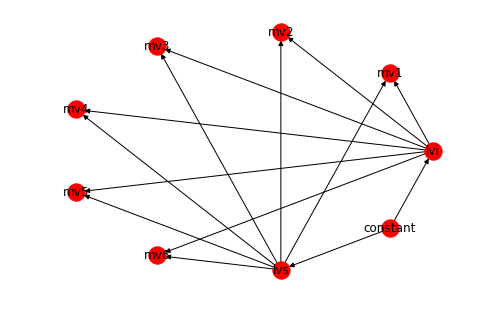

In [107]:
import networkx as nx
nx.draw(trial_graph_output, with_labels = True, pos = nx.circular_layout(trial_graph_output))

From the above graph we can see that we read in the data into the class correctly. Then it is a simple matter of creating the symbols that will be used for the symbolic matrix math, and then creating the three matrices used in the calculations. 

In [108]:
trial_symbols = trial_expectations.create_symbols()
trial_matrix_f = trial_expectations.create_matrix_f(trial_symbols)
trial_matrix_a = trial_expectations.create_matrix_a(trial_symbols)
trial_matrix_s = trial_expectations.create_matrix_s(trial_symbols)

Now, it will be a simple matter of inputing the matrices into the final function.

In [110]:
Expectations.calculate_expectations(trial_matrix_f, trial_matrix_a, trial_matrix_s, latentvars, manifestvars)

Matrix([
[            2*Cov(lvi & lvs) + Var(error) + Var(lvi) + Var(lvs) + (Mean(lvi) + Mean(lvs))**2,    3*Cov(lvi & lvs) + Var(lvi) + 2*Var(lvs) + (Mean(lvi) + Mean(lvs))*(Mean(lvi) + 2*Mean(lvs)),    4*Cov(lvi & lvs) + Var(lvi) + 3*Var(lvs) + (Mean(lvi) + Mean(lvs))*(Mean(lvi) + 3*Mean(lvs)),     5*Cov(lvi & lvs) + Var(lvi) + 4*Var(lvs) + (Mean(lvi) + Mean(lvs))*(Mean(lvi) + 4*Mean(lvs)),     6*Cov(lvi & lvs) + Var(lvi) + 5*Var(lvs) + (Mean(lvi) + Mean(lvs))*(Mean(lvi) + 5*Mean(lvs)),     7*Cov(lvi & lvs) + Var(lvi) + 6*Var(lvs) + (Mean(lvi) + Mean(lvs))*(Mean(lvi) + 6*Mean(lvs)),   Mean(lvi) + Mean(lvs)],
[3*Cov(lvi & lvs) + Var(lvi) + 2*Var(lvs) + (Mean(lvi) + Mean(lvs))*(Mean(lvi) + 2*Mean(lvs)),            4*Cov(lvi & lvs) + Var(error) + Var(lvi) + 4*Var(lvs) + (Mean(lvi) + 2*Mean(lvs))**2,  5*Cov(lvi & lvs) + Var(lvi) + 6*Var(lvs) + (Mean(lvi) + 2*Mean(lvs))*(Mean(lvi) + 3*Mean(lvs)),   6*Cov(lvi & lvs) + Var(lvi) + 8*Var(lvs) + (Mean(lvi) + 2*Mean(lvs))*(Mean(lvi) + 4*Mean(lv

The output is unwieldly at this point with six time points, but the goal is to continue to work on this and add in all of the different kinds of Structural Equation Models that have different assumptions from the above examples. However, the above usage is more in line with what I would use it for. 